* E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by Firecracker.
* Inside this sandbox is a running Jupyter server that the LLM can use.




In [1]:
! pip install -q "groq==0.11.0" "e2b_code_interpreter==1.0.1" "python-dotenv==1.0.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os
from dotenv import load_dotenv

Groq_api_key = userdata.get('GROQ_API_KEY')
E2B_api_key  = userdata.get('E2B_API_KEY')

In [3]:
# MODEL_NAME = "llama3-8b-8192"
MODEL_NAME = "llama3-70b-8192"

SYSTEM_PROMPT = """you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment"""


tools = [
  {
    "type": "function",
      "function": {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "parameters": {
          "type": "object",
          "properties": {
            "code": {
              "type": "string",
              "description": "The python code to execute in a single cell.",
            }
          },
          "required": ["code"],
        },
      },
  }
]

In [4]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

```
def match_code_blocks(text):
  pattern = re.compile(r'```(?:python)?[\n\r](.*?)```', re.DOTALL)
  return pattern.findall(text)
```
Instead of using the above code, we will use function calling with execute_python

In [5]:
import json
import re
from groq import Groq

client = Groq(api_key=Groq_api_key)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls

  if tool_calls:
    for tool_call in tool_calls:
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        return code_interpreter_results
      else:
        raise Exception(f"Unknown tool {function_name}")
  else:
    print(f"(No tool call in model's response) {response_message}")
    return []


User message: Visualize a distribution of height of men based on the latest data you know
Running code interpreter...


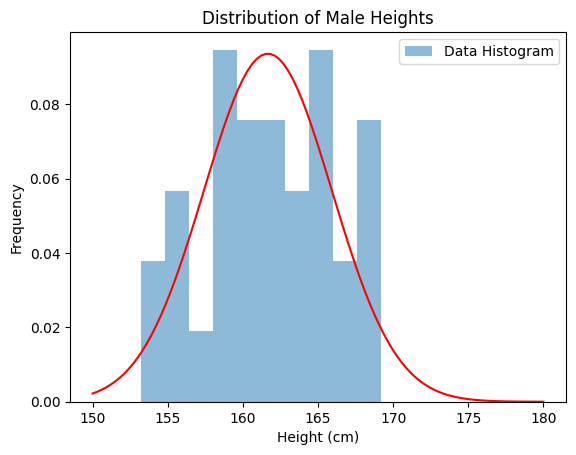

In [6]:
from e2b_code_interpreter import Sandbox

with Sandbox(api_key=E2B_api_key) as code_interpreter:
  code_results = chat_with_llama(
    code_interpreter,
    "Visualize a distribution of height of men based on the latest data you know"
  )
  if code_results:
    first_result = code_results[0]
  else:
    print("No code results")
    exit(0)


first_result


User message: Visualize the Sri Lankan population based on the latest data you know
Running code interpreter...


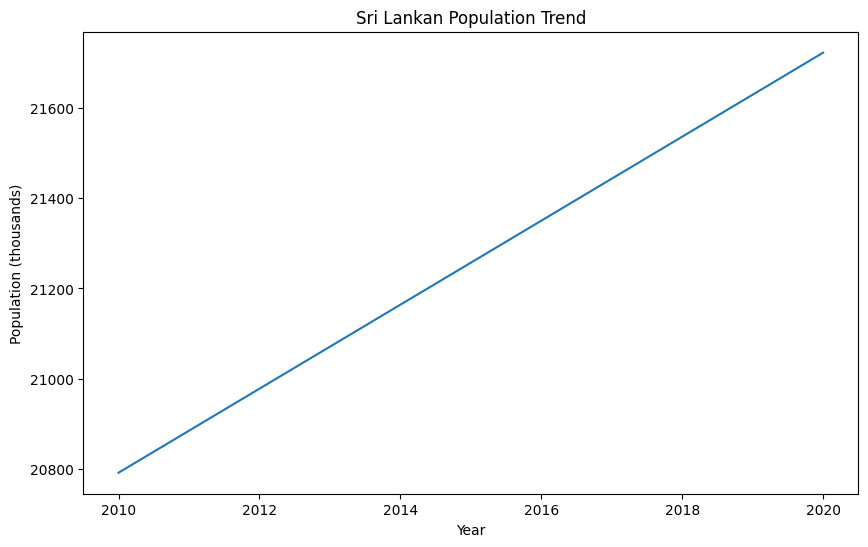

In [8]:
from e2b_code_interpreter import Sandbox

with Sandbox(api_key=E2B_api_key) as code_interpreter:
  code_results = chat_with_llama(
    code_interpreter,
    "Visualize the Sri Lankan population based on the latest data you know"
  )
  if code_results:
    first_result = code_results[0]
  else:
    print("No code results")
    exit(0)


first_result